In [6]:
# -------------------------------
# 2_Pure_introgression.ipynb
# -------------------------------

# === Setup ===
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Path Setup
notebook_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in globals() else os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
simulations_path = os.path.join(project_root, 'simulations')
if simulations_path not in sys.path:
    sys.path.insert(0, simulations_path)

# Imports from simulation utilities
from common_utils import (
    simulate_introgression_scenario,
    calculate_d_statistic,
    calculate_fst,
    save_dataframe,
    plot_kde_distribution,
    sliding_window_d
)

# === Parameters ===
os.makedirs("../results/dstat_distributions", exist_ok=True)
os.makedirs("../results/fst_distributions", exist_ok=True)
os.makedirs("../results/sliding_windows", exist_ok=True)
os.makedirs("../figures", exist_ok=True)

n_replicates = 50
Ne = 100000
div_time_abc = 400000
div_time_ab = 800000

migration_times = {
    "recent": 10000,
    "intermediate": 50000,
    "ancient": 200000
}
migration_rates = {
    "none": 0.0,
    "low": 1e-6,
    "moderate": 1e-4,
    "high": 1e-2
}

# === Run Simulations ===
results = []

for mig_time_label, mig_time in migration_times.items():
    for mig_rate_label, mig_rate in migration_rates.items():
        for rep in tqdm(range(n_replicates), desc=f"{mig_time_label}-{mig_rate_label}"):
            ts = simulate_introgression_scenario(
                Ne=Ne,
                div_time_ab=div_time_ab,
                div_time_abc=div_time_abc,
                mig_rate=mig_rate,
                mig_time=mig_time,
                migration_direction="C_to_B",
                continuous=False
            )

            d_stat, abba, baba = calculate_d_statistic(ts)
            fst_ab, fst_bc = calculate_fst(ts)

            results.append({
                "rep": rep,
                "mig_time": mig_time_label,
                "mig_rate": mig_rate_label,
                "D": d_stat,
                "ABBA": abba,
                "BABA": baba,
                "FST_AB": fst_ab,
                "FST_BC": fst_bc
            })

# === Save Results ===
df = pd.DataFrame(results)
save_dataframe(df, "../results/dstat_distributions/pure_introgression.csv")
save_dataframe(df, "../results/fst_distributions/pure_introgression.csv")


ancient-high: 100%|██████████| 50/50 [01:29<00:00,  1.80s/it]


# Plotting code

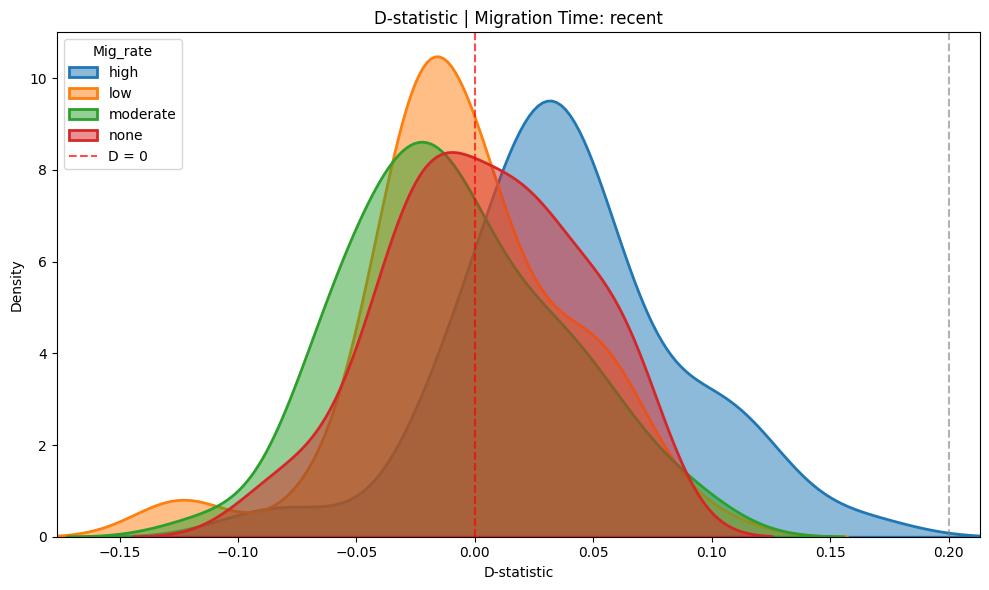

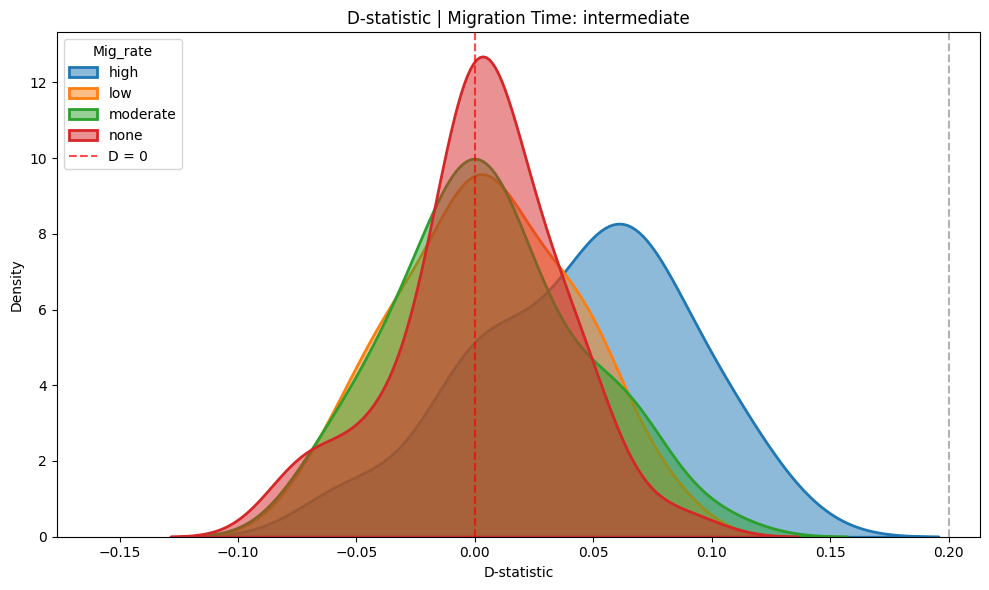

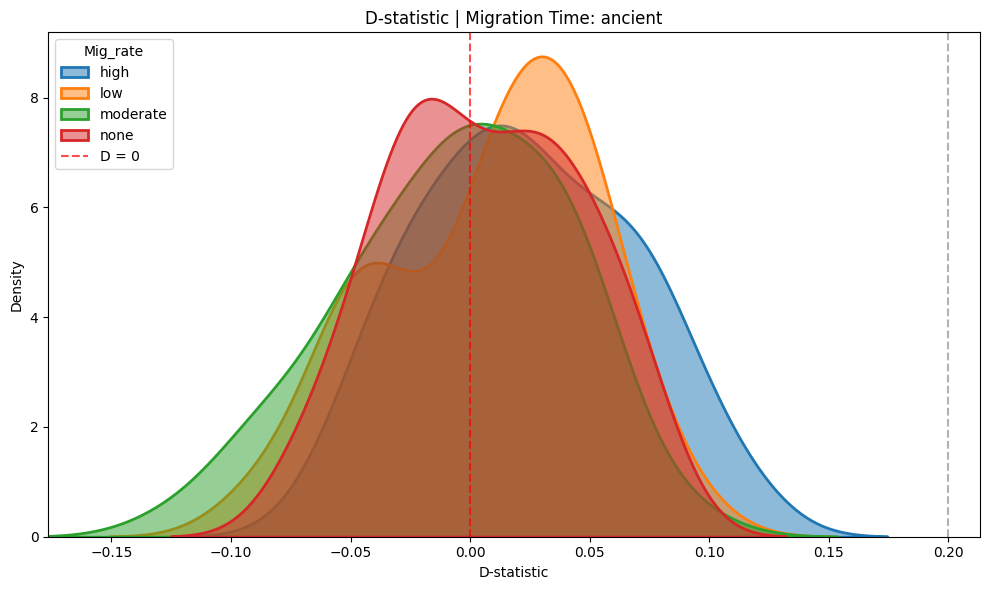

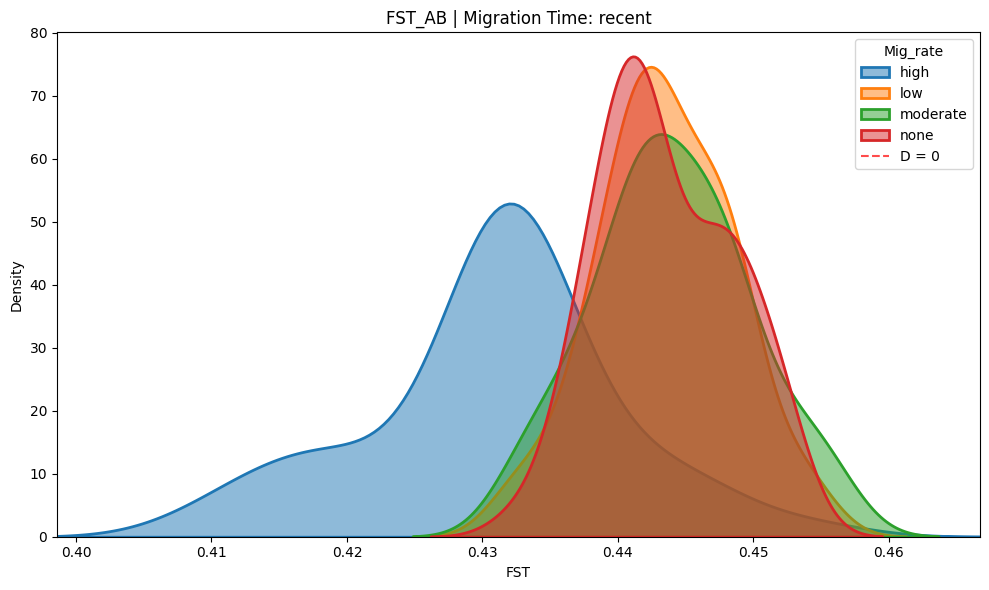

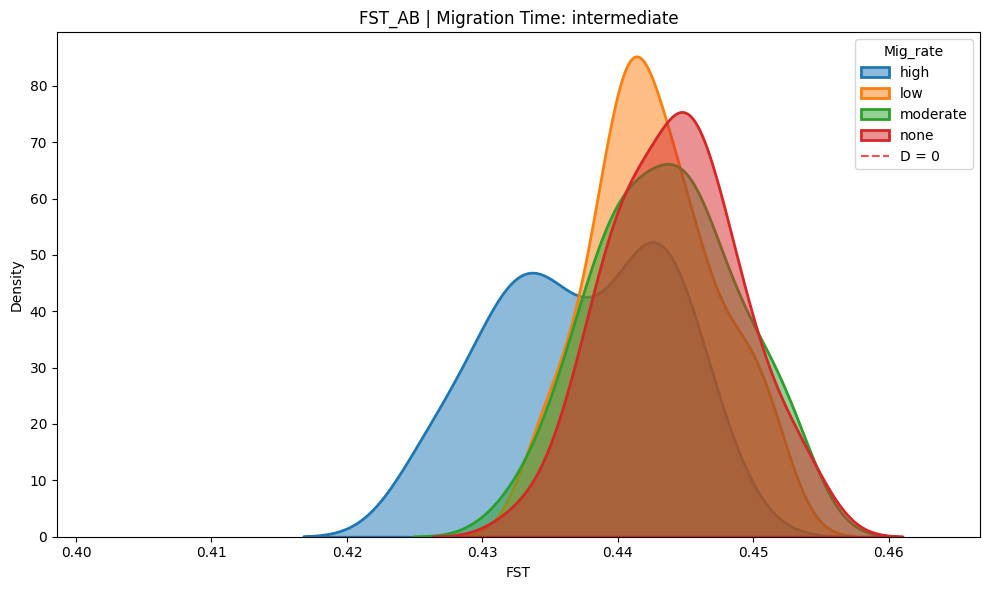

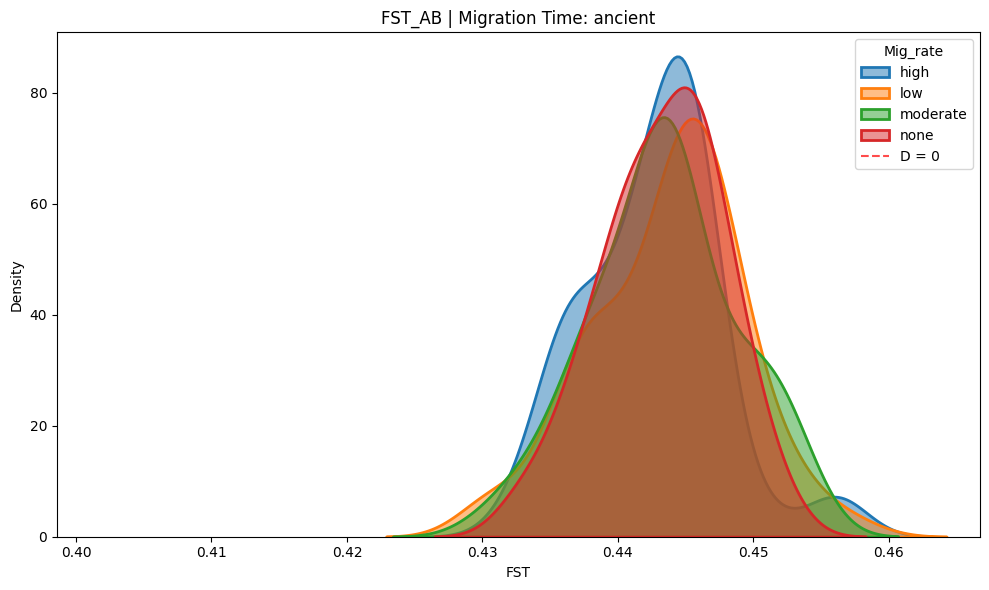

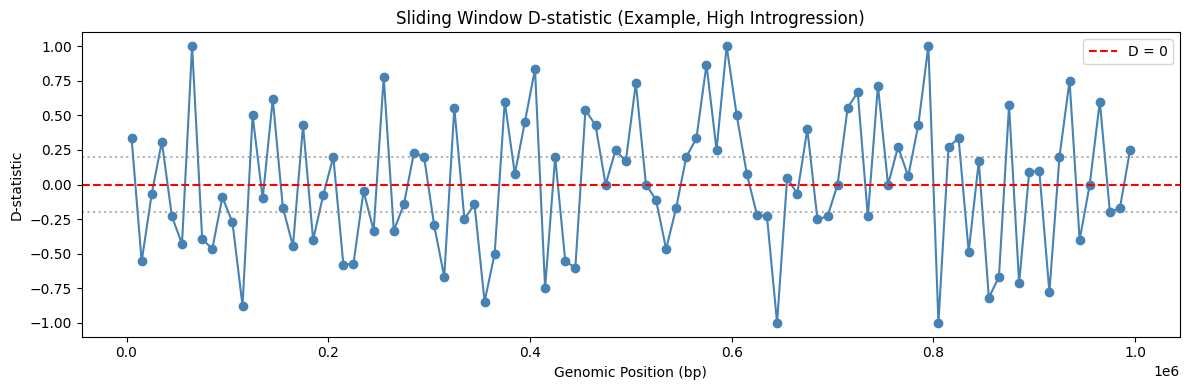

In [7]:

# === Compute Dynamic Axis Limits ===
d_margin = 0.05
fst_margin = 0.01
d_xmin, d_xmax = df["D"].min() - d_margin, df["D"].max() + d_margin
fst_xmin, fst_xmax = df["FST_AB"].min() - fst_margin, df["FST_AB"].max() + fst_margin

# === Plot KDEs for D-stat ===
for mig_time in df["mig_time"].unique():
    subset = df[df["mig_time"] == mig_time]
    plot_kde_distribution(
        data=subset,
        group_col="mig_rate",
        value_col="D",
        title=f"D-statistic | Migration Time: {mig_time}",
        xlabel="D-statistic",
        output_path=f"../figures/dstat_introgression_{mig_time}.png",
        xlim=(d_xmin, d_xmax),
        sig_lines=[-0.2, 0.2]
    )

# === Plot KDEs for FST ===
for mig_time in df["mig_time"].unique():
    subset = df[df["mig_time"] == mig_time]
    plot_kde_distribution(
        data=subset,
        group_col="mig_rate",
        value_col="FST_AB",
        title=f"FST_AB | Migration Time: {mig_time}",
        xlabel="FST",
        output_path=f"../figures/fst_introgression_{mig_time}.png",
        xlim=(fst_xmin, fst_xmax)
    )

# === Sliding Window D-statistic ===
example_ts = simulate_introgression_scenario(
    Ne=Ne,
    div_time_ab=div_time_ab,
    div_time_abc=div_time_abc,
    mig_rate=1e-2,  # High migration
    mig_time=10000,
    migration_direction="C_to_B",
    continuous=False
)

mids, d_stats = sliding_window_d(example_ts)
plt.figure(figsize=(12, 4))
plt.plot(mids, d_stats, marker='o', linestyle='-', color='steelblue')
plt.axhline(0, color='red', linestyle='--', label="D = 0")
plt.axhline(0.2, color='gray', linestyle=':', alpha=0.6)
plt.axhline(-0.2, color='gray', linestyle=':', alpha=0.6)
plt.title("Sliding Window D-statistic (Example, High Introgression)")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("D-statistic")
plt.tight_layout()
plt.savefig("../figures/sliding_d_introgression_example.png", dpi=300)
plt.legend()
plt.show()

## Continuous vs Episodic + FST_BC + Directionality Comparisons

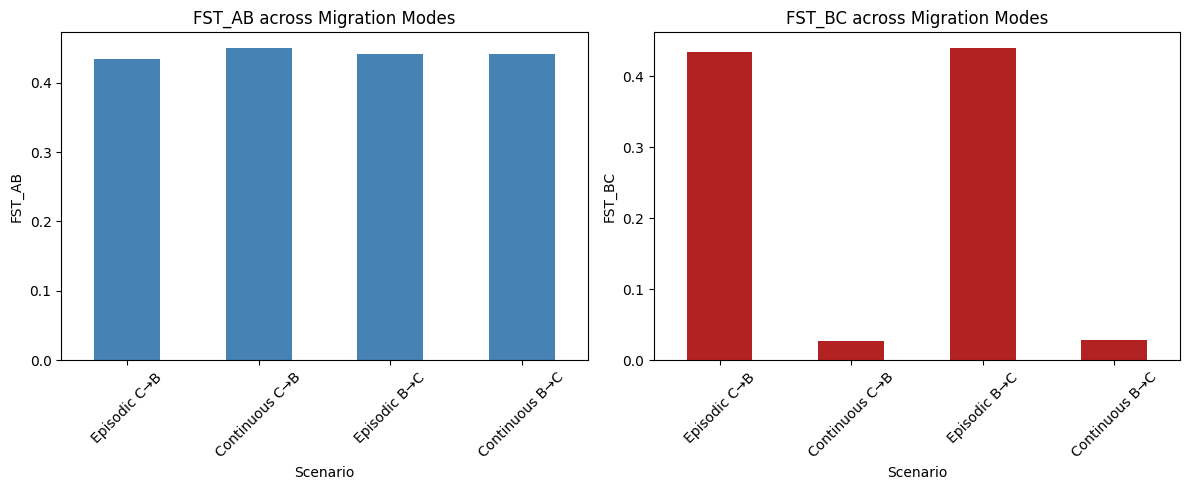

In [8]:
# ------------------------------------------
# 🔍 Continuous vs Episodic + Directionality
# FST_AB and FST_BC comparisons
# ------------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
from common_utils import simulate_introgression_scenario, calculate_fst
from pathlib import Path

# Ensure output directory
Path("../figures").mkdir(parents=True, exist_ok=True)

# Fixed parameters
Ne = 100000
div_time_ab = 800000
div_time_abc = 400000
mig_rate = 1e-2
mig_time = 10000

results = []

# Four modes: episodic/continuous × direction
modes = {
    "Episodic C→B": {"continuous": False, "direction": "C_to_B"},
    "Continuous C→B": {"continuous": True, "direction": "C_to_B"},
    "Episodic B→C": {"continuous": False, "direction": "B_to_C"},
    "Continuous B→C": {"continuous": True, "direction": "B_to_C"},
}

for label, config in modes.items():
    ts = simulate_introgression_scenario(
        Ne=Ne,
        div_time_ab=div_time_ab,
        div_time_abc=div_time_abc,
        mig_rate=mig_rate,
        mig_time=mig_time,
        continuous=config["continuous"],
        migration_direction=config["direction"]
    )
    fst_ab, fst_bc = calculate_fst(ts)
    results.append({
        "Scenario": label,
        "FST_AB": fst_ab,
        "FST_BC": fst_bc
    })

df_modes = pd.DataFrame(results)

# Plot FST comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

df_modes.plot(kind="bar", x="Scenario", y="FST_AB", ax=axes[0], color="steelblue", legend=False)
axes[0].set_title("FST_AB across Migration Modes")
axes[0].set_ylabel("FST_AB")
axes[0].tick_params(axis='x', rotation=45)

df_modes.plot(kind="bar", x="Scenario", y="FST_BC", ax=axes[1], color="firebrick", legend=False)
axes[1].set_title("FST_BC across Migration Modes")
axes[1].set_ylabel("FST_BC")
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("../figures/fst_bc_directionality_comparison.png", dpi=300)
plt.show()


##  Sliding window FST visualization between populations B and C

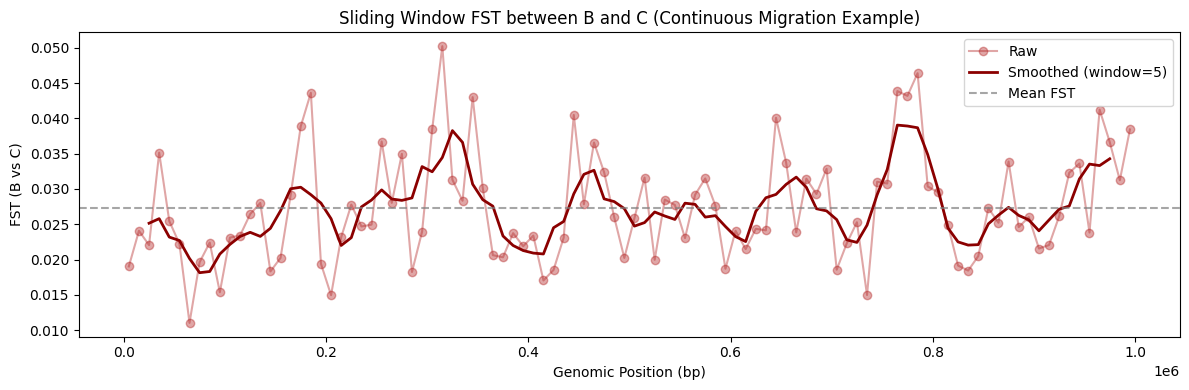

In [9]:
def sliding_window_fst(ts, window_size=10000):
    """Compute FST in sliding windows between populations B and C."""
    genotypes = ts.genotype_matrix()
    positions = np.array([v.position for v in ts.variants()])
    samples = np.array([ts.get_population(n) for n in ts.samples()])
    
    b_idx = np.where(samples == 1)[0]
    c_idx = np.where(samples == 2)[0]

    windows = np.arange(0, ts.sequence_length, window_size)
    if windows[-1] < ts.sequence_length:
        windows = np.append(windows, ts.sequence_length)

    mids = []
    fst_vals = []

    for i in range(len(windows) - 1):
        start, end = windows[i], windows[i + 1]
        indices = (positions >= start) & (positions < end)
        sites = np.where(indices)[0]

        if len(sites) == 0:
            continue

        hap1 = genotypes[sites][:, b_idx]
        hap2 = genotypes[sites][:, c_idx]

        p1 = np.mean(hap1, axis=1)
        p2 = np.mean(hap2, axis=1)

        n1, n2 = len(b_idx), len(c_idx)
        p_bar = (n1 * p1 + n2 * p2) / (n1 + n2)

        h_s = (n1 * p1 * (1 - p1) + n2 * p2 * (1 - p2)) / (n1 + n2)
        h_t = p_bar * (1 - p_bar)

        valid = h_t > 0
        if np.sum(valid) == 0:
            continue

        fst = 1 - np.mean(h_s[valid] / h_t[valid])
        fst_vals.append(fst)
        mids.append((start + end) / 2)

    return mids, fst_vals


# Simulate a high migration scenario as example
ts_example = simulate_introgression_scenario(
    Ne=100000,
    div_time_ab=800000,
    div_time_abc=400000,
    mig_rate=1e-2,
    mig_time=10000,
    continuous=True,
    migration_direction="C_to_B"
)

mids, fst_vals = sliding_window_fst(ts_example)

# Optional smoothing using rolling average
window_size = 5
smoothed_fst = pd.Series(fst_vals).rolling(window=window_size, center=True).mean()

plt.figure(figsize=(12, 4))
plt.plot(mids, fst_vals, marker='o', linestyle='-', alpha=0.4, color='firebrick', label="Raw")
plt.plot(mids, smoothed_fst, color='darkred', linewidth=2, label=f"Smoothed (window={window_size})")
plt.axhline(np.mean(fst_vals), linestyle="--", color="gray", alpha=0.7, label="Mean FST")
plt.title("Sliding Window FST between B and C (Continuous Migration Example)")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("FST (B vs C)")
plt.legend()
plt.tight_layout()
plt.savefig("../figures/sliding_fst_bc_example_smoothed.png", dpi=300)
plt.show()


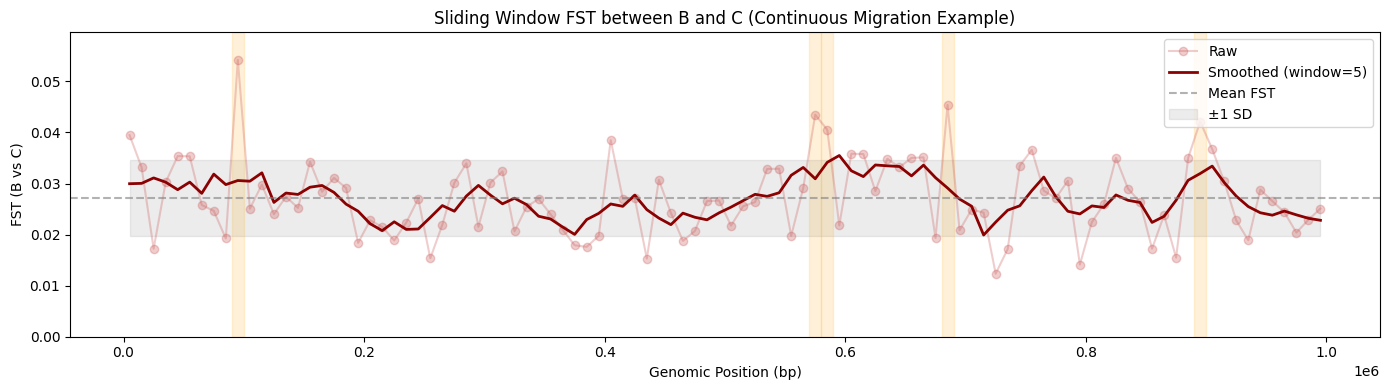

In [10]:
def sliding_window_fst(ts, window_size=10000):
    """Compute FST in sliding windows between populations B and C."""
    genotypes = ts.genotype_matrix()
    positions = np.array([v.position for v in ts.variants()])
    samples = np.array([ts.get_population(n) for n in ts.samples()])
    
    b_idx = np.where(samples == 1)[0]
    c_idx = np.where(samples == 2)[0]

    windows = np.arange(0, ts.sequence_length, window_size)
    if windows[-1] < ts.sequence_length:
        windows = np.append(windows, ts.sequence_length)

    mids = []
    fst_vals = []

    for i in range(len(windows) - 1):
        start, end = windows[i], windows[i + 1]
        indices = (positions >= start) & (positions < end)
        sites = np.where(indices)[0]

        if len(sites) == 0:
            continue

        hap1 = genotypes[sites][:, b_idx]
        hap2 = genotypes[sites][:, c_idx]

        p1 = np.mean(hap1, axis=1)
        p2 = np.mean(hap2, axis=1)

        n1, n2 = len(b_idx), len(c_idx)
        p_bar = (n1 * p1 + n2 * p2) / (n1 + n2)

        h_s = (n1 * p1 * (1 - p1) + n2 * p2 * (1 - p2)) / (n1 + n2)
        h_t = p_bar * (1 - p_bar)

        valid = h_t > 0
        if np.sum(valid) == 0:
            continue

        fst = 1 - np.mean(h_s[valid] / h_t[valid])
        fst_vals.append(fst)
        mids.append((start + end) / 2)

    return mids, fst_vals


# Simulate a high migration scenario as example
ts_example = simulate_introgression_scenario(
    Ne=100000,
    div_time_ab=800000,
    div_time_abc=400000,
    mig_rate=1e-2,
    mig_time=10000,
    continuous=True,
    migration_direction="C_to_B"
)

# Compute FST values
mids, fst_vals = sliding_window_fst(ts_example)
smoothed = pd.Series(fst_vals).rolling(window=5, center=True, min_periods=1).mean()

# Plotting
plt.figure(figsize=(14, 4))
plt.plot(mids, fst_vals, 'o-', color='indianred', alpha=0.3, label='Raw')
plt.plot(mids, smoothed, color='darkred', linewidth=2, label='Smoothed (window=5)')

# Mean and Std Dev lines
mean_fst = np.mean(fst_vals)
std_fst = np.std(fst_vals)
plt.axhline(mean_fst, linestyle="--", color="gray", alpha=0.6, label="Mean FST")
plt.fill_between(mids, mean_fst - std_fst, mean_fst + std_fst, color="gray", alpha=0.15, label="±1 SD")

# Highlight 95th percentile windows
threshold = np.percentile(fst_vals, 95)
for i, val in enumerate(fst_vals):
    if val > threshold:
        plt.axvspan(mids[i] - 5000, mids[i] + 5000, color='orange', alpha=0.15)

plt.title("Sliding Window FST between B and C (Continuous Migration Example)")
plt.xlabel("Genomic Position (bp)")
plt.ylabel("FST (B vs C)")
plt.ylim(0, max(fst_vals)*1.1)
plt.legend()
plt.tight_layout()
plt.savefig("../figures/sliding_fst_bc_enhanced.png", dpi=300)
plt.show()

# Save for reuse
fst_df = pd.DataFrame({"position": mids, "fst": fst_vals})
fst_df.to_csv("../results/fst_windows_bc.csv", index=False)
